In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn import mixture
from sklearn import metrics
from matplotlib.colors import LogNorm
import itertools
from scipy import linalg
import matplotlib as mpl
import pandas as pd

In [13]:
from sklearn import cluster
import time
from itertools import cycle, islice
from sklearn.neighbors import kneighbors_graph

In [2]:
def plot_results(X, Y_, means, covariances, index, title):
    colors = ['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange']
    plt.figure(figsize=(5,5))
    splot = plt.subplot(1, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, colors)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1],.3, color=color) #,marker='o', color=color, alpha=0.2)
        
        
        
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
        plt.plot(mean[0],mean[1],'r*')
    
    plt.plot([-2,3],[-2,3],'k')
    plt.plot([-2,3],[-1,4],'k')
    plt.plot([-2,3],[0,5],'k')
    plt.xlim(-2., 3.)
    plt.ylim(-2., 3.)
    plt.xlabel('log T2 (ms)')
    plt.ylabel('log T1 (ms)')
    #plt.xticks(())
    #plt.yticks(())
    plt.title(title)    
    
def plot_coun(T2_den_v, T1_den_v, clf):
    x = np.linspace(-2., 3.)
    y = np.linspace(-2., 3.)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -clf.score_samples(XX)
    Z = Z.reshape(X.shape)
    plt.figure(figsize=(5,5))
    CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=0.5, vmax=10),
                     levels=np.arange(1,10,0.5))
    plt.plot(T2_den_v,T1_den_v,'o',markersize=2, alpha=0.1)
    
def plot_raw(T2_grid, T1_grid, T1T2, title='sample', do_pcolor =True):
    plt.figure(figsize=(5,5))
    ax = plt.subplot()
    if do_pcolor:
        ax.pcolormesh(T2_grid, T1_grid, T1T2, cmap='RdBu',shading='gouraud')
    else:
        ax.contour(T2_grid, T1_grid, T1T2,20, cmap='RdBu' )
    plt.plot([1e-2,1e3],[1e-2,1e3],'k')
    plt.plot([1e-2,1e3],[1e-1,1e4],'k')
    plt.plot([1e-2,1e3],[1,1e5],'k')
    plt.xlim(1e-2,1e3)
    plt.ylim(1e-2,1e3)
    plt.title(title)
    #plt.colorbar()
    plt.xlabel('T2 (ms)')
    plt.ylabel('T1 (ms)')
    ax.set_xscale("log")
    ax.set_yscale("log")

In [3]:
def to_density(T2_grid, T1_grid, T1T2, ratio=0.1, scale = 0.01):
    """
    
    Returns:
        X_raw_v: 2D matrix,
    """
    T1T2_max = np.max(T1T2) 
    T1T2_min = ratio * T1T2_max
    id_T1T2 =  (T1T2 > T1T2_min) & (T1_grid >= T2_grid) & ( T1_grid < 600) 
    
    
    #id_T1T2 = T1T2 > T1T2_min
    T1T2_crop = np.round(np.array(T1T2)/(T1T2_min)*1) # convert to number
    T1T2_crop[~id_T1T2]=0
    
    # flatten to 1D
    T2_v = np.reshape(T2_grid, (-1,1)).flatten()
    T1_v =np.reshape(T1_grid, (-1,1)).flatten()
    T1T2_v = np.reshape(T1T2, (-1,1)).flatten()
    
    
    
    T1T2_crop_v = np.reshape(T1T2_crop, (-1,1)).flatten().astype(int)
    
    # save X_raw only for id_T1T2
    id_v_notzero = T1T2_crop_v > 0
    X_raw_v = np.vstack([np.log10(T2_v[id_v_notzero]), np.log10(T1_v[id_v_notzero]), T1T2_v[id_v_notzero]]).T
    
    
    # convert intensity to density
    T2_den_v = []
    T1_den_v = []
    for i,value in enumerate(T1T2_crop_v):
        if value >0:
            t2_list = np.array([np.log10(T2_v[i])] * value) + np.random.randn(1,value) * scale
            t2_list.flatten()
            t1_list = [np.log10(T1_v[i])] * value + np.random.randn(1,value) * scale
            t1_list.flatten()
            
            T2_den_v.extend(t2_list[0])
            T1_den_v.extend(t1_list[0])
        #break
    X_train = np.vstack([np.array(T2_den_v), np.array(T1_den_v)]).T
    
    return X_train, X_raw_v

def label_mapping(centers, labels, weights = None ):
    """ To reassign the label based on the position. 
        Wihtout this, clustering algorithm will always randomly assign the label values 
    
    """
    df_data = pd.DataFrame(centers, columns = ['T2','T1'])
    df_data['labels_old'] = labels
    if weights is not None:
        df_data['weights'] = weights
    for i in range(df_data.shape[0]):
        if df_data.loc[i,'T2'] < -0.5:
            print(df_data.loc[i,'T2'])
            df_data.loc[i,'T1/T2'] = df_data.loc[i,'T1']
        else:
            df_data.loc[i,'T1/T2'] = df_data.loc[i,'T2']+10
    df_data.sort_values('T1/T2', inplace=True)
    df_data['labels_new'] = range(df_data.shape[0])
    mapping = {label: i for i,label in enumerate(df_data['labels_old'])} 
    #print(df_data)
    return mapping, df_data[['T2','T1','labels_new']].values
#print(a, mapping)
#mapping = label_mapping(BG.means_, BG.predict(BG.means_))
#print(mapping)

In [4]:
def main(X_grid, Y_grid, Z_grid, n_components, title):
    #for i,file in enumerate(filenames):
        
    #plot_raw(X_grid, Y_grid, Z_grid)
    X_den_v, Y_den_v, _,_,_ = to_density(X_grid, Y_grid, Z_grid, ratio=0.15, scale = 0.00) 

    X_train = np.vstack([np.array(X_den_v), np.array(Y_den_v)]).T
    #X_train_more = np.vstack([np.array(X_den_v), np.array(Y_den_v), np.array(X_den_v)/ np.array(Y_den_v)]).T
    #print(X_train_more.shape, X_train_more[:3,:])
    # gaussian mix
    #if use_more:
        #X_train = np.array(X_train_more)
    print(X_train.shape)
    clf_G = mixture.GaussianMixture(n_components=n_components, covariance_type='full',max_iter=1000)
    clf_G.fit(X_train)

    #plot_results(X_train, clf_G.predict(X_train), clf_G.means_, clf_G.covariances_, 0,
             #'gaussian '+title)
    
    mapping,_ = label_mapping(clf_G.means_, clf_G.predict(clf_G.means_))
    old_labels = (clf_G.predict(X_train))
    new_labels = np.array([mapping[old] for old in old_labels])
    plot_results(X_train, new_labels, clf_G.means_, clf_G.covariances_, 0,
             'Gaussian '+ title)
    # B G mix

    clf_BG = mixture.BayesianGaussianMixture(n_components=n_components, covariance_type='full',max_iter=2000)
    clf_BG.fit(X_train)
    #plot_results(X_train, clf_BG.predict(X_train), clf_BG.means_, clf_BG.covariances_, 0,
             #'VBGMM '+ title)
    
    # add mappings 
    mapping, _ = label_mapping(clf_BG.means_, clf_BG.predict(clf_BG.means_))
    old_labels = (clf_BG.predict(X_train))
    new_labels = np.array([mapping[old] for old in old_labels])
    plot_results(X_train, new_labels, clf_BG.means_, clf_BG.covariances_, 0,
             'VBGMM '+ title)
    
#print(np.exp(clf.means_))
    return clf_G, clf_BG, X_train

In [5]:
T1_domain = np.loadtxt('data_T1T2/T1_point.txt')
T2_domain = np.loadtxt('data_T1T2/T2_point.txt')
T1_domain.shape, T2_domain.shape
T2_grid,T1_grid = np.meshgrid(T2_domain,T1_domain)

### process the data, if you have the data, then skip this section

In [6]:
first_time = False
if first_time:
    filenames  = ['data_T1T2\Pro_T1T2_3_14_H_20_35_2_03272016.txt',
                  'data_T1T2\Pro_T1T2_3_14_H_20_35_21_05092016.txt',
                  'data_T1T2\Pro_T1T2_3_14_h_20_35_250c_08132016.txt',
                  'data_T1T2\Pro_T1T2_3_14_h_20_35_450c_09192016.txt',
                  'data_T1T2\Pro_T1T2_3_14_h_20_35_650c.txt',                              
    ]
    sample_name = '3_14'
    temperatures = ['30c','110c','250c','450c','600c']
    ratio = 0.1
    scale = 0.01
    for i,file in enumerate(filenames):
        Z_grid = np.loadtxt(file)
        X_train, X_raw_v = to_density(T2_grid, T1_grid, Z_grid, ratio=ratio, scale = scale) 
        #X_train = np.vstack([np.array(X_den_v), np.array(Y_den_v)]).T
        print(X_train.shape, X_raw_v.shape)
        print(np.sum(Z_grid), np.sum(X_raw_v[:,2]) )
        np.savetxt('process_data\X_train_S{}_T{}_R{}_Sca{}.txt'.format(sample_name,temperatures[i],ratio,scale), X_train)
        np.savetxt('process_data\X_raw_S{}_T{}_R{}_Sca{}.txt'.format(sample_name,temperatures[i],ratio,scale), X_raw_v)

### The raw data is without convert to density

In [7]:
first_tim = False
if first_time:
    filenames  = ['data_T1T2\Pro_T1T2_2_93_P_20_35_0(a)_05152016.txt',
                  'data_T1T2\Pro_T1T2_2_93_P_20_35_1_110c_06062016.txt',
                  'data_T1T2\Pro_T1T2_2_93_P_20_35_250c_08292016.txt',
                  'data_T1T2\Pro_T1T2_2_93_P_20_35_450c_10022016.txt',
                  'data_T1T2\Pro_T1T2_2_93_P_20_35_650c.txt',                
    ]
    sample_name = '2_93'
    temperatures = ['30c','110c','250c','450c','600c']
    ratio = 0.1
    scale = 0.01
    for i,file in enumerate(filenames):
        Z_grid = np.loadtxt(file)
        X_train, X_raw_v = to_density(T2_grid, T1_grid, Z_grid, ratio=ratio, scale = scale) 
        #X_train = np.vstack([np.array(X_den_v), np.array(Y_den_v)]).T
        
        print(X_train.shape, X_raw_v.shape)
        print(np.sum(Z_grid), np.sum(X_raw_v[:,2]) )
        np.savetxt('process_data\X_train_S{}_T{}_R{}_Sca{}.txt'.format(sample_name,temperatures[i],ratio,scale), X_train)
        np.savetxt('process_data\X_raw_S{}_T{}_R{}_Sca{}.txt'.format(sample_name,temperatures[i],ratio,scale), X_raw_v)

### Loading data

(10662, 2) (2823, 3)
(9324, 2) (2497, 3)
(11486, 2) (3103, 3)
(12902, 2) (3086, 3)
(13741, 2) (3496, 3)


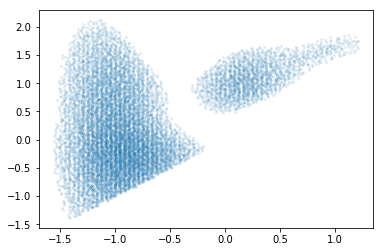

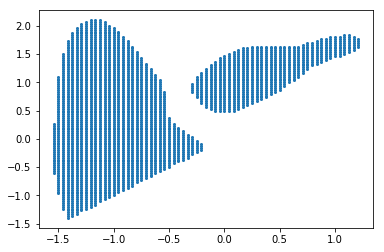

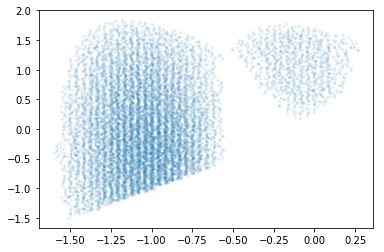

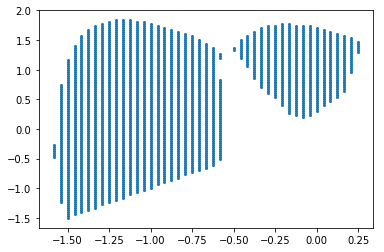

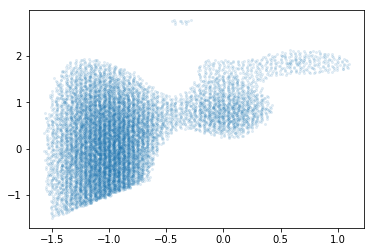

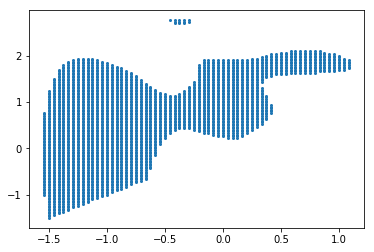

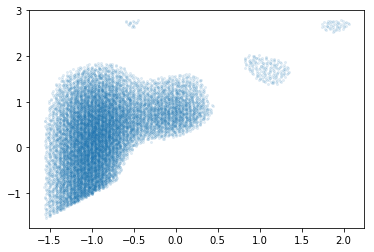

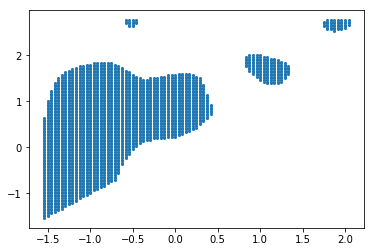

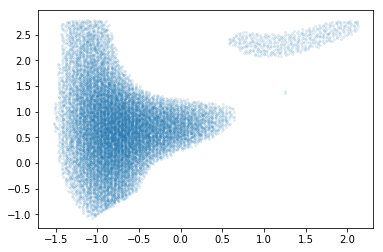

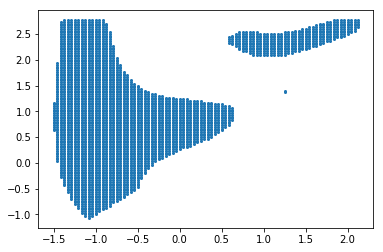

In [8]:
data_3_14_train ={}
data_3_14_raw = {}
#sample_names = ['2_93']
temperatures = ['30c','110c','250c','450c','600c']
scale = 0.01
ratio = 0.1
sample_name = '3_14'
for i,t in enumerate(temperatures):
    data_3_14_train[t] = np.loadtxt('process_data\X_train_S{}_T{}_R{}_Sca{}.txt'.format(
        sample_name,temperatures[i],ratio,scale))
    data_3_14_raw[t] = np.loadtxt('process_data\X_raw_S{}_T{}_R{}_Sca{}.txt'.format(
        sample_name,temperatures[i],ratio,scale))
    
    print(data_3_14_train[t].shape, data_3_14_raw[t].shape)
    plt.figure()
    plt.plot(data_3_14_train[t][:,0], data_3_14_train[t][:,1], 'o', markersize=2, alpha=0.1)
    plt.figure()
    plt.plot(data_3_14_raw[t][:,0], data_3_14_raw[t][:,1],'o',markersize=2, ) #, data_3_14_raw[t][:,2]) # 'o', markersize=2, alpha=0.1)
    #plt.xlim(-2,3)
    #plt.ylim(-2,3)

### singple training

In [9]:
X_train = data_3_14_train['30c']
X_raw = data_3_14_raw['30c']


In [173]:
BG_args = {'n_components': 5,
            'covariance_type' : 'full',
            'max_iter' : 2000,
           'tol':1e-4,
          
             }
mod_BG = mixture.BayesianGaussianMixture(**BG_args)
y_BG = train_model(mod_BG, X_train)

-0.835958149848
-1.13203566689
-1.05311249085
-0.950334418754


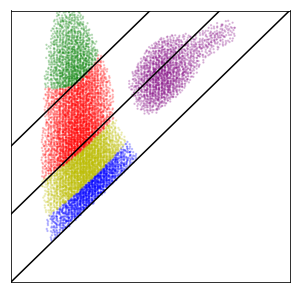

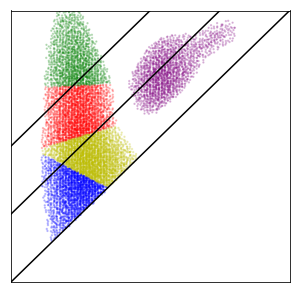

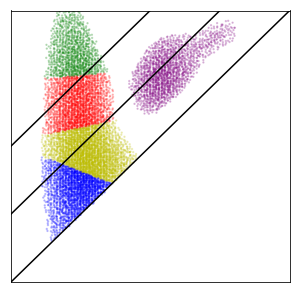

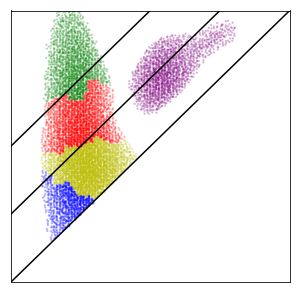

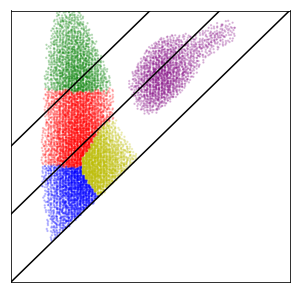

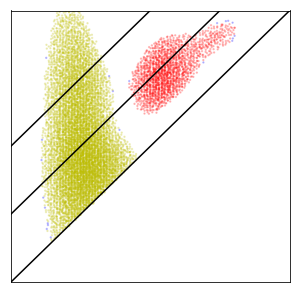

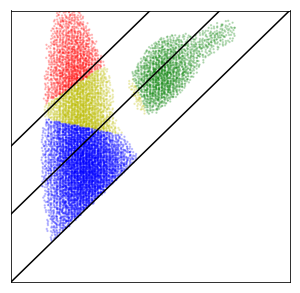

In [178]:
y_list = {'BG':y_BG,
          'kmean':y_kmean,
         'mini_kmean':y_two_means,
          'ward': y_ward,
          'spectral': y_spectral,
          'dbscan': y_dbscan,
          'birch':y_birch
         
         }
for y in y_list:
    plot_result(X_train, y_list[y], 'model_'+y)

In [171]:
def plot_result(X_train, y_pred, model_name = 'model',plot_line = True, plot_center = False):
    colors = np.array(list(islice(cycle(['b', 'y','r', 'g','purple']),int(max(y_pred) + 1))))
    plt.figure(figsize=(5,5))
    plt.scatter(X_train[:, 0], X_train[:, 1], s=2, color=colors[y_pred], alpha=0.2)
    
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    plt.xticks([])
    plt.yticks([])
    
    if plot_line:
        plt.plot([-2,3],[-2,3],'k')
        plt.plot([-2,3],[-1,4],'k')
        plt.plot([-2,3],[-0,5],'k')
    if plot_center:
        for (x,y,label) in centers:
            plt.text(x,y,int(label), fontsize=19)
            plt.plot(x,y,'k*')
   
        #plt.xlabel(r'$\log{T_2}$')
        #plt.ylabel(r'$\log{T_1}$')
        
    plt.savefig(model_name)
        
def do_score(X_train, y_pred):
    return metrics.silhouette_score(X_train, y_pred, metric='euclidean')

def train_model(model,X_train):
    model.fit(X_train)
    if hasattr(model, 'labels_'):
        y_pred = model.labels_.astype(np.int)
    else:
        y_pred = model.predict(X_train)
    # remapping 
    centers_model = approx_centers(X_train, y_pred)
    n_components = max(y_pred)+1
    
    #mapping_model, centers_model = label_mapping(model.cluster_centers_, model.predict(model.cluster_centers_))
    mapping_model, centers_model = label_mapping(centers_model, list(range(n_components)))
    y_pred_new = np.array([mapping_model[y] for y in y_pred])
    return y_pred_new

def approx_centers(X_train,y_pred):
    # sometime need to calculate the approximate center
    n_components = max(y_pred)+1
    centers = []
    for i in range(n_components):
        x,y = np.mean(X_train[y_pred==i], axis=0)
        centers.append([x,y])
    return np.array(centers)

-1.04855581513
-0.841223356547
-0.942248446856
-1.12003864105
0.37541734932
0.61661931771
0.809872875
0.29972017277
0.41657041492


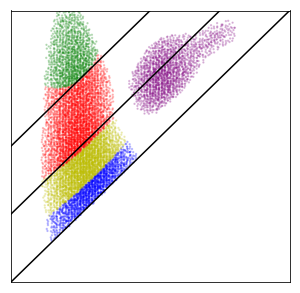

In [70]:
# remapping 
"""  Mixture Gaussian models """
y_pred = mod_BG.predict(X_train)
mapping, centers= label_mapping(mod_BG.means_, mod_BG.predict(mod_BG.means_), mod_BG.weights_) # get remapping dict
y_pred_new = np.array([mapping[y] for y in y_pred]) # apply remapping

# do the raw data
y_pred_BG_raw = mod_BG.predict(X_raw[:,:2])
y_pred_raw_new = np.array([mapping[yraw] for yraw in y_pred_BG_raw])

n_components = max(y_pred_raw_new)+1
#print(n_components)
sum_ = np.zeros((n_components,1))
for i in range(n_components):
    sum_i = sum(X_raw[y_pred_raw_new == i,2])
    print(sum_i)
    sum_[i] = sum_i

# plot
plot_result(X_train,y_pred_new)

### clustering performance evalution

In [58]:
do_score(X_train,y_pred_new)

0.30710007097494707

### compare with kmean

In [182]:
""" initial algorithms"""

n_clusters = 5

# kmean 
kmean = cluster.KMeans(n_clusters = n_clusters , n_init = 20)
# minibtach kmean 
two_means = cluster.MiniBatchKMeans(n_clusters=n_clusters)
# spectral 
spectral = cluster.SpectralClustering(
    n_clusters=n_clusters, eigen_solver='arpack',
    affinity="nearest_neighbors")
# ward
ward = cluster.AgglomerativeClustering(n_clusters= n_clusters,linkage ='ward')
# complete
complete = cluster.AgglomerativeClustering(n_clusters= n_clusters,linkage ='complete')
#  birch  
birch = cluster.Birch(n_clusters=n_clusters)
# mean_shift 
bandwidth = cluster.estimate_bandwidth(X_train, quantile=.1)
mean_shift = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)

algorithms = {
    'kmean': kmean,
    'mini_kmean': two_means,
    'spectral': spectral,
    'ward': ward,
    'complete':complete,
    'birch': birch,
    'mean_shift':mean_shift
}


In [ ]:
y_pred_list = []
for name in algorithms:
    print(name)
    y_pred = train_model(algorithms[name], X_train)
    y_pred_list.append(y_pred)
    plot_result(X_train,y_pred,model_name=name)

kmean
-1.04276707523
-1.11417954296
-1.07712674287
-0.829828593
mini_kmean
-1.11686340975
-1.08620529663
-1.04901894403
-0.7774482984


### compare with dbscan

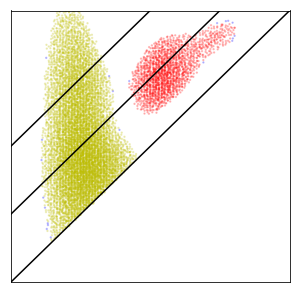

In [164]:
dbscan = cluster.DBSCAN(eps=0.05,min_samples=5)
y_dbscan = dbscan.fit_predict(X_train)
y_dbscan = y_dbscan + 1
plot_result(X_train, y_dbscan)

### do individual plots

In [133]:
""" Plot i """
# this is do plot 
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
def get_silhouette(X_train, y_pred, n_clusters = 5):
    n_clusters = 5
    
    silhouette_avg = silhouette_score(X_train, y_pred)
    sample_silhouette_values = silhouette_samples(X_train, y_pred)
    print(silhouette_avg)
    return silhouette_avg, sample_silhouette_values
def plot_silhouette( silhouette_avg, sample_silhouette_values, y_pred, n_clusters = 5):
    #plt.figure(figsize=(8,8))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_pred == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color=colors[i]
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples   
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([ -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [139]:
sil_avg, sample_sil = get_silhouette(X_train, y_pred_kmean_new, n_clusters = 5)

0.413085901624


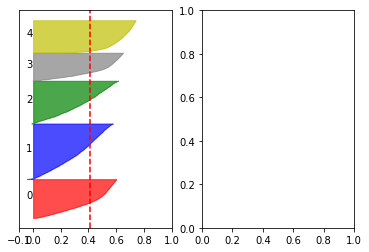

In [140]:
plot_silhouette(sil_avg, sample_sil, y_pred_kmean_new)

In [65]:
metrics.silhouette_score(X_train, y_pred_ward, metric='euclidean')

0.39451577348057759

### Compare with Affinity propagation

### For multiple samples

In [197]:
BG_args = {'n_components': 5,
            'covariance_type' : 'full',
            'max_iter' : 2000,
           'tol':1e-4,
           'warm_start':True,
           'random_state':1
             }
mod_BG_list = []
for temp in temperatures:
    X_train = data_3_14_train[temp]
    X_raw  = data_3_14_raw[temp]
    print(temp)
    
    # train the model
    mod_BG = None
    mod_BG = mixture.BayesianGaussianMixture(**BG_args)
    mod_BG.fit(X_train)
    mod_BG_list.append(mod_BG)

30c
110c
250c
450c
600c


30c
-0.841042401765
-1.1176328272
-1.04861669305
-0.941822378193
5
the sum
 [ 0.37541735  0.6154082   0.80549911  0.30530505  0.41657041]
110c
-1.1719825322
-1.01519162852
-1.04480348167
-1.08486566102
5
the sum
 [ 0.16324717  0.29423818  0.41527499  0.1007145   0.10282971]
250c
-1.05536948845
-0.982292787891
-0.992427492815
-1.19709338945
5
the sum
 [ 0.08189988  0.14289364  0.25655256  0.05583102  0.12035607]
450c
-0.921597229045
-1.05903248725
-1.05732878397
5
the sum
 [ 0.0616604   0.20448714  0.1290657   0.07681803  0.0096426 ]
600c
-0.886894951012
-0.817181259349
-1.08002402709
5
the sum
 [ 0.05004116  0.15208229  0.04136022  0.05060152  0.01147189]


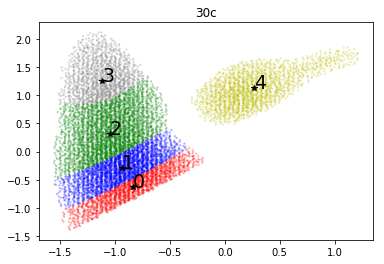

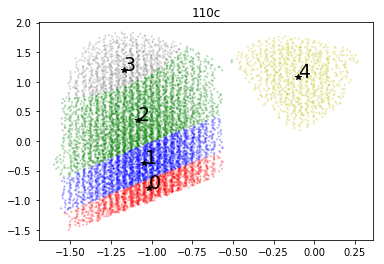

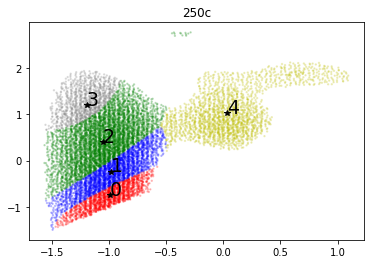

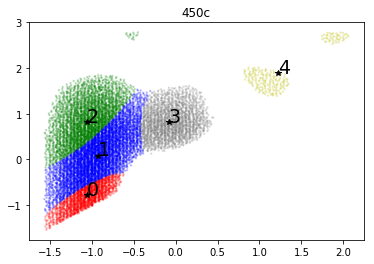

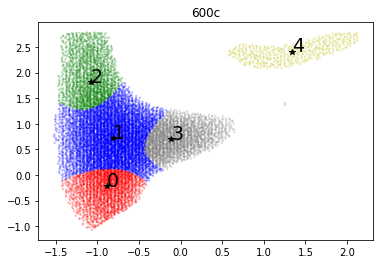

In [199]:
for i,temp in enumerate(temperatures):
    
    print(temp)
    mod_BG = mod_BG_list[i]
    X_train = data_3_14_train[temp]
    X_raw  = data_3_14_raw[temp]
    y_pred = mod_BG.predict(X_train)
    mapping, centers= label_mapping(mod_BG.means_, mod_BG.predict(mod_BG.means_), mod_BG.weights_)
    y_pred_new = np.array([mapping[y] for y in y_pred])
    plt.figure()
    plt.scatter(X_train[:, 0], X_train[:, 1], s=2, color=colors[y_pred_new], alpha=0.2)
    for (x,y,label) in centers:
        plt.text(x,y,int(label), fontsize=19)
        plt.plot(x,y,'k*')
    plt.title(temp)
    
    
        
    y_pred_raw = mod_BG.predict(X_raw[:,:2])
    y_pred_raw_new = np.array([mapping[yraw] for yraw in y_pred_raw])

    n_components = max(y_pred_raw_new)+1
    print(n_components)
    sum_ = np.zeros((n_components))
    for i in range(n_components):
        sum_i = sum(X_raw[y_pred_raw_new == i,2])
        
        sum_[i] = sum_i
    print('the sum\n', sum_)

### test for  multiple output

In [99]:

BG_args = {'n_components': 5,
            'covariance_type' : 'full',
            'max_iter' : 2000,
           'tol':1e-4,
           'warm_start':False 
             }

#y_pred_new = np.array([mapping[y_old] for y_old in y_pred])
centers_list = []
for i in range(20):
    print(i)
    mod_BG = None
    mod_BG = mixture.BayesianGaussianMixture(**BG_args)
    mod_BG.fit(X_train)
    y_pred = mod_BG.predict(X_train)
    mapping, centers = label_mapping(mod_BG.means_, mod_BG.predict(mod_BG.means_))
    centers_list.append(centers)
        
        
#plt.subplot(1, len(clustering_algorithms), plot_num)
       


0
-0.942342963303
-1.11572301672
-1.04924614232
-0.838318570317
1
-0.943150054108
-1.0491830928
-0.838637837907
-1.11754414019
2
-0.943250428524
-1.11522787808
-0.83853206811
-1.04935546085
3
-0.838498473243
-1.11517490808
-0.942909906973
-1.04926496894
4
-1.01665938683
-0.850042529481
-1.0662017687
5
-0.942156466492
-1.11568500862
-1.04921886089
-0.838280772351
6
-0.943376824024
-1.11546136484
-0.838572924921
-1.04935448952
7
-1.11500240732
-0.838443621095
-0.942735203421
-1.04926278462
8
-0.943374386375
-1.1154602027
-0.838572219459
-1.04935436484
9
-0.942224930332
-1.1155013897
-1.04924620068
-0.838280324185
10
-0.83828737893
-1.04902674186
-1.1160648753
-0.941690249254
11
-1.04893466284
-0.838154619657
-1.11641101833
-0.941067129995
12
-0.838286988675
-1.04902667295
-1.11606422495
-0.941688934571
13
-1.11499825131
-0.838445003533
-0.942740329987
-1.04926330796
14
-1.04907059621
-0.941457730602
-1.11657665048
-0.838171361957
15
-1.01682215575
-0.849959001214
-1.06659748008
16
-1.065

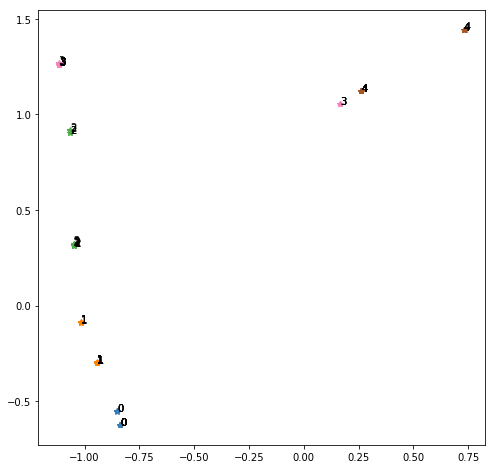

In [100]:
plt.figure(figsize=(8,8))
#plt.scatter(X_train[:, 0], X_train[:, 1], s=2, alpha=0.1) # color=colors[y_pred], alpha=0.2)
for i,centers in enumerate(centers_list):
    if i >-1:
        for j,(x,y,label) in enumerate(centers):
            plt.text(x,y,int(label))
            plt.plot(x,y,'*',color = colors[j])

In [77]:
centers

array([[-0.83818754, -0.6244462 ,  0.        ],
       [-0.94151627, -0.2998998 ,  1.        ],
       [-1.04907258,  0.31676514,  2.        ],
       [-1.11683486,  1.26449717,  3.        ],
       [ 0.26282868,  1.12166993,  4.        ]])

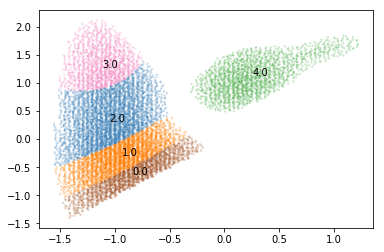

In [78]:
#plt.title(name, size=10)
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
      int(max(y_pred) + 1))))
plt.scatter(X_train[:, 0], X_train[:, 1], s=2, color=colors[y_pred], alpha=0.2)
for (x,y,label) in centers:
    plt.text(x,y,int(label))

### Build the model

In [10]:
if 0:
    Z_grid = np.loadtxt('Pro_T1T2_4_34_20_35_20171118.txt') 
    X_den_v, Y_den_v = to_density(T2_grid, T1_grid, Z_grid, ratio=0.1, scale = 0.01) 
    X_train = np.vstack([np.array(X_den_v), np.array(Y_den_v)]).T
    np.savetxt('X_train_4_34_30c.txt', X_train)

In [11]:
if 0:
    R_domain = np.loadtxt('R_domain.txt')
    Ts_domain = np.loadtxt('Ts_domain.txt')
    R_grid,Ts_grid = np.meshgrid(R_domain,Ts_domain)

In [12]:
filenames  = ['RTS\Pro_G_grid_3_14_H_20_35_2_03272016.txt',
              #'RTS\Pro_G_grid_3_14_H_20_35_21_05092016.txt',
              #'RTS\Pro_G_grid_3_14_h_20_35_250c_08132016.txt',
              #'RTS\Pro_G_grid_3_14_h_20_35_450c_09192016.txt',
              #'RTS\Pro_G_grid_3_14_h_20_35_650c.txt',                
]
n_components_list_BG = [10,10,4,4,5]
n_components_list_G =  [5,4,4,4,5]
if 0:
    main1(filenames, R_grid, Ts_grid, n_components_list_BG, n_components_list_G)


(6831, 2)
-0.881793056275
-1.02331160107
-1.06981846886
-1.05828419132
-0.950734054149
-1.10283878798
-1.04607998319
-0.834617284303
(5846, 2)
-1.06330689066
-1.08542557989
-1.07892410764
-1.059421988
-1.11790431859
-1.08518113287
-1.02380594866
-1.05886804406
(7258, 2)
-1.07146286569
-0.980965282419
-1.0510401382
-1.04671228174
-1.00210497001
-1.02751172245
-1.1228491929
-1.03817300444


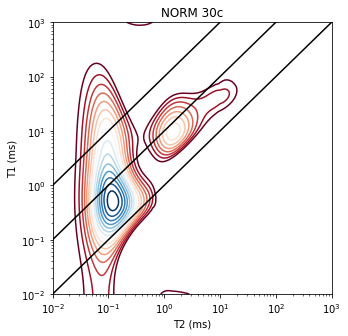

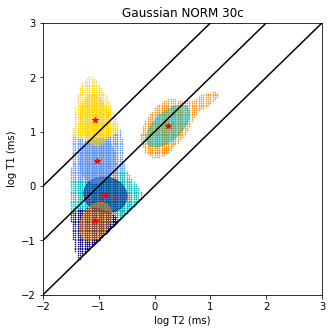

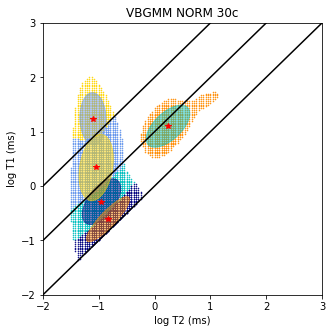

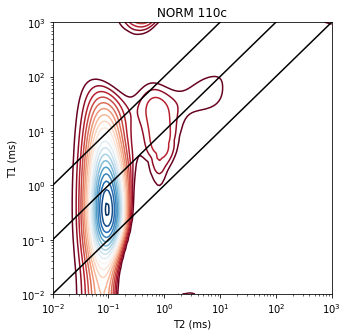

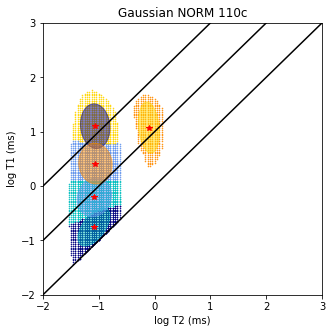

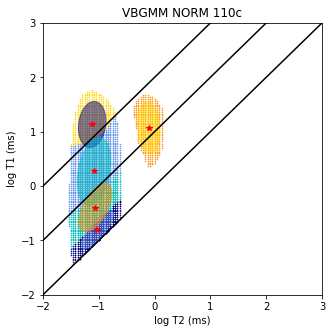

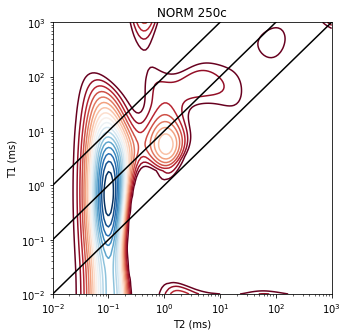

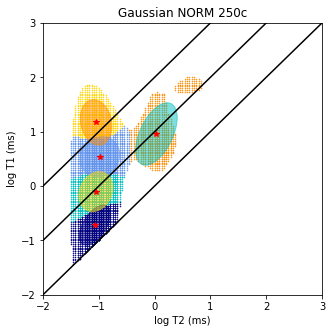

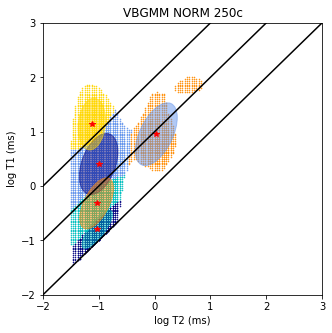

In [118]:
filenames  = ['data_T1T2\Pro_T1T2_3_14_H_20_35_2_03272016.txt',
              'data_T1T2\Pro_T1T2_3_14_H_20_35_21_05092016.txt',
              'data_T1T2\Pro_T1T2_3_14_h_20_35_250c_08132016.txt',
              #'data_T1T2\Pro_T1T2_3_14_h_20_35_450c_09192016.txt',
              #'data_T1T2\Pro_T1T2_3_14_h_20_35_650c.txt',                
]
n_components_list_BG = [5,5,5,5,5]
n_components_list_G =  [5,5,5,5,5]
model_Gs = []
model_BGs = []
titles = ['NORM 30c','NORM 110c','NORM 250c','NORM 450c','NORM 650c']
for i,file in enumerate(filenames):
    Z_grid = np.loadtxt(file) 
    plot_raw(T2_grid, T1_grid, Z_grid, titles[i])
    clf_G, clf_BG, X_train = main(T2_grid, T1_grid, Z_grid, n_components_list_G[i], titles[i])
    model_Gs.append(clf_G)
    model_BGs.append(clf_BG)

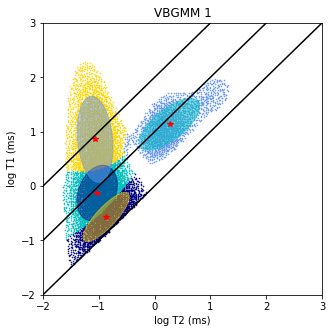

In [65]:
#for BG in  model_BGs:
    #print(BG.means_)
    #print(BG.predict(BG.means_))
    #plt.plot(x,y,'*')
#plt.xlim(-2,3)
#plt.ylim(-2,3)
mapping = label_mapping(clf_BG.means_, clf_BG.predict(BG.means_))
old_labels = (clf_BG.predict(X_train))
new_labels = np.array([mapping[old] for old in old_labels])
plot_results(X_train, new_labels, clf_BG.means_, clf_BG.covariances_, 0,
             'VBGMM '+ '1')
#

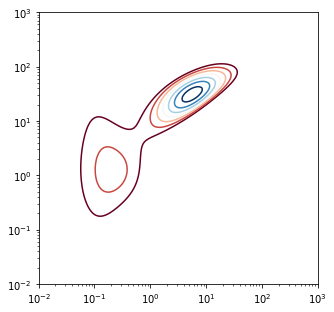

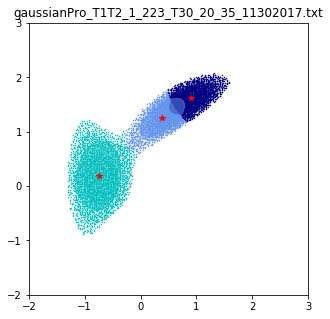

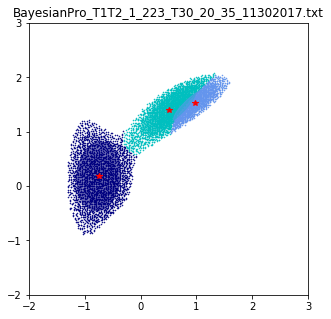

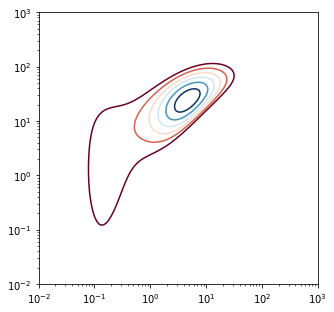

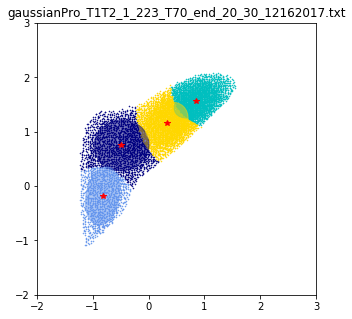

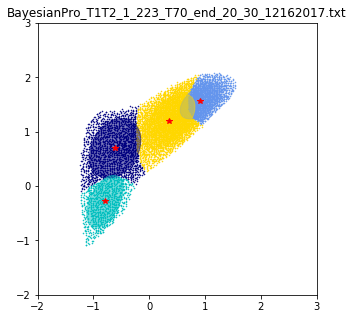

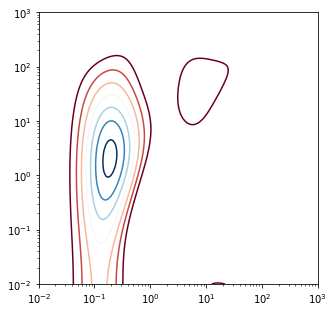

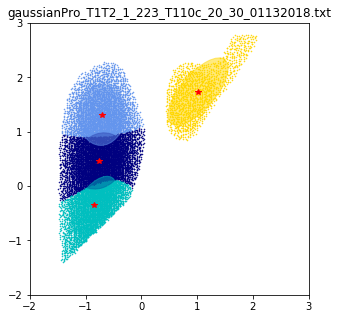

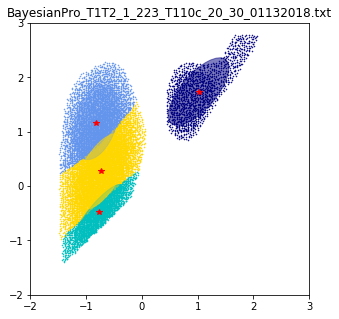

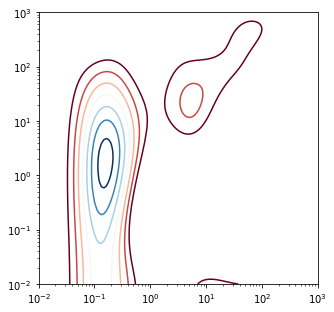

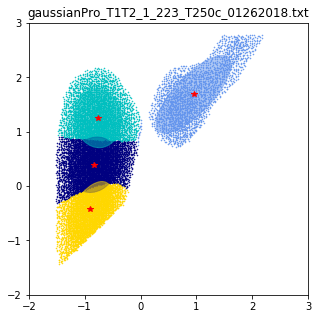

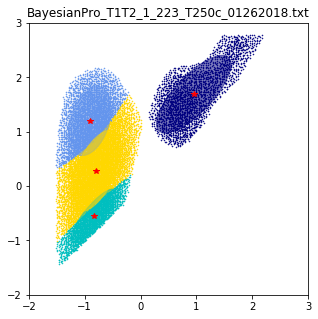

In [545]:
filenames  = ['Pro_T1T2_1_223_T30_20_35_11302017.txt',
              'Pro_T1T2_1_223_T70_end_20_30_12162017.txt',
              'Pro_T1T2_1_223_T110c_20_30_01132018.txt',
              'Pro_T1T2_1_223_T250c_01262018.txt',
              #'Pro_T1T2_3_14_h_20_35_650c.txt',                
]
n_components_list_G = [3,4,4,4,5]
n_components_list_BG = [3,4,4,4,5]
main(filenames,n_components_list_G, n_components_list_BG)

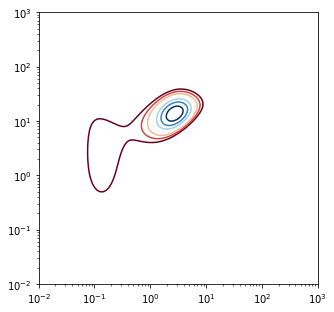

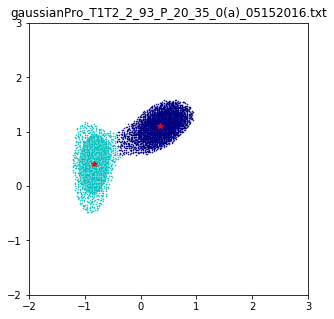

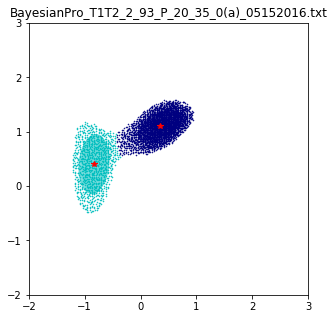

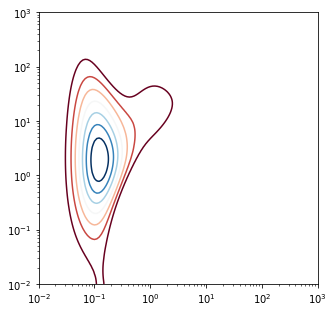

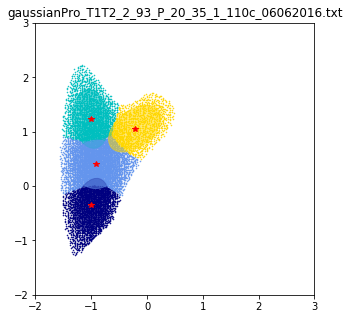

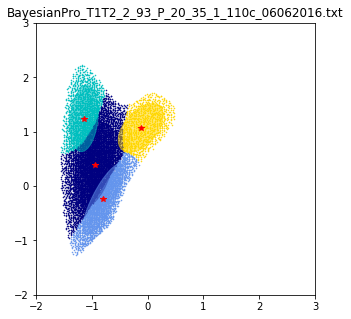

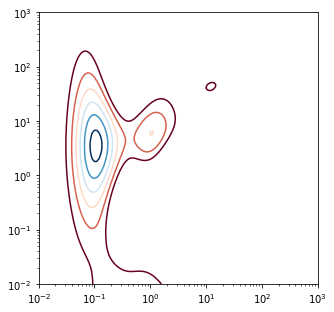

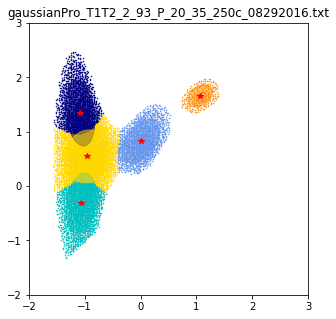

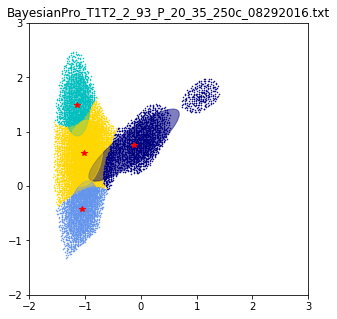

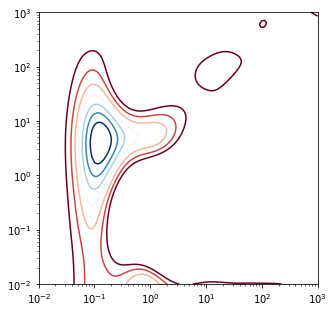

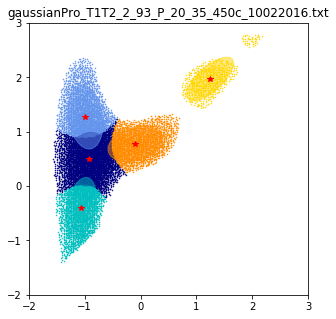

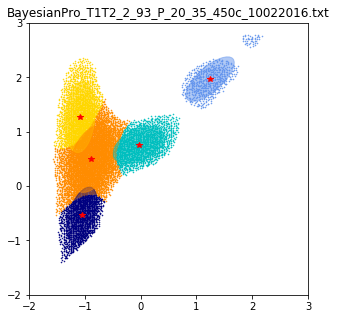

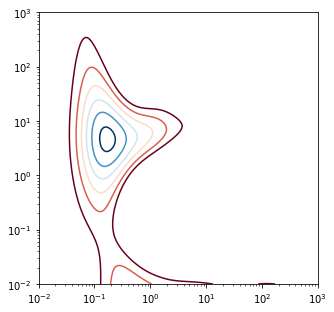

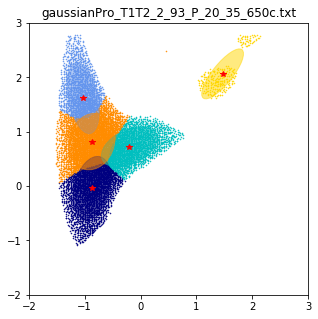

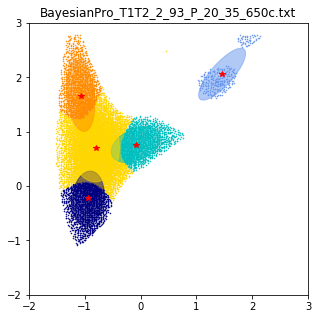

In [548]:
filenames  = ['Pro_T1T2_2_93_P_20_35_0(a)_05152016.txt',
              'Pro_T1T2_2_93_P_20_35_1_110c_06062016.txt',
              'Pro_T1T2_2_93_P_20_35_250c_08292016.txt',
              'Pro_T1T2_2_93_P_20_35_450c_10022016.txt',
              'Pro_T1T2_2_93_P_20_35_650c.txt',                
]
n_components_list_G = [2,4,5,5,5]
n_components_list_BG = [2,4,5,5,5]
main(filenames,n_components_list_G, n_components_list_BG)

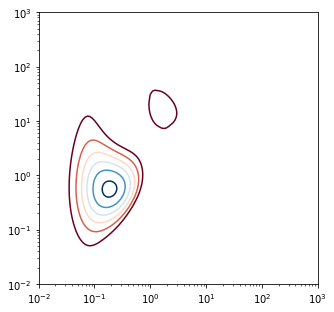

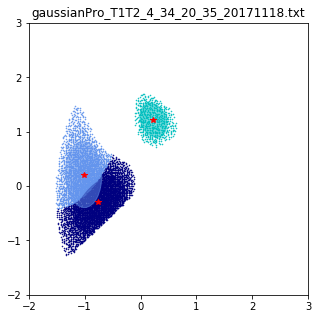

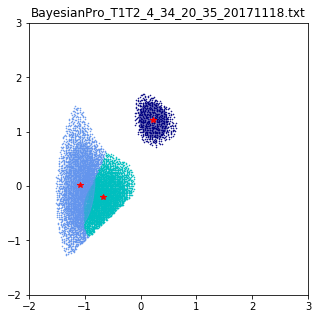

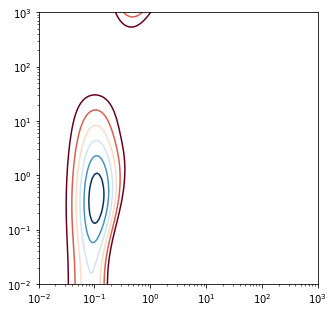

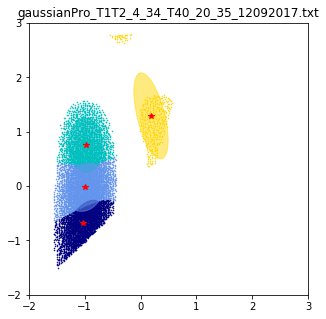

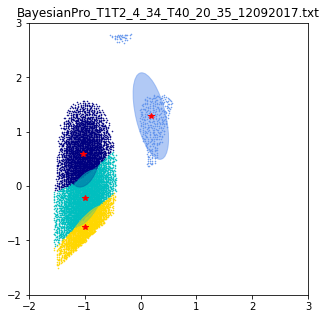

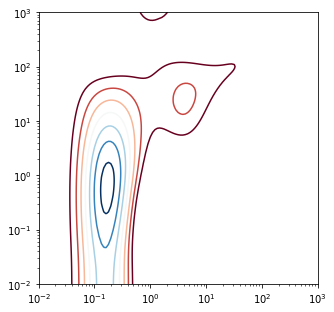

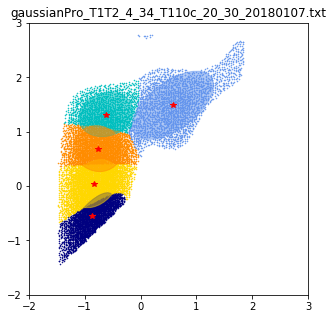

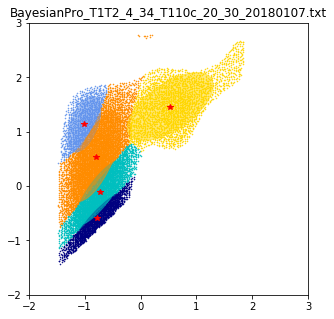

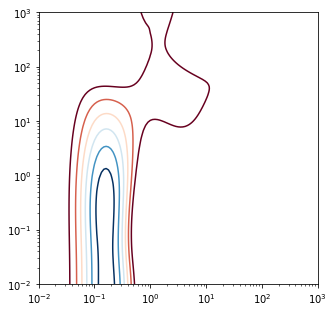

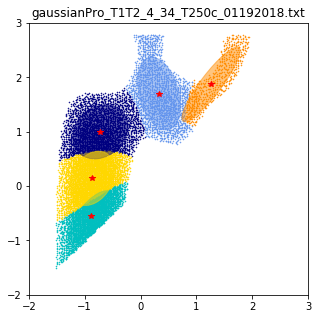

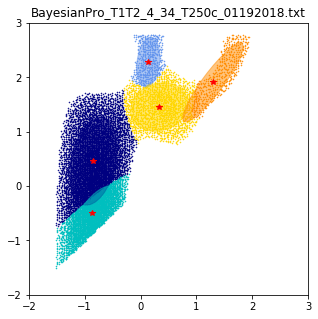

In [550]:
filenames  = ['Pro_T1T2_4_34_20_35_20171118.txt',
              'Pro_T1T2_4_34_T40_20_35_12092017.txt',
              'Pro_T1T2_4_34_T110c_20_30_20180107.txt',
              'Pro_T1T2_4_34_T250c_01192018.txt',
              #'Pro_T1T2_2_93_P_20_35_650c.txt',                
]
n_components_list_G = [3,4,5,5,5]
n_components_list_BG = [3,4,5,5,4]
main(filenames,n_components_list_G, n_components_list_BG)

(11246, 2)
kmean: 0.175
MiniBatchKMeans: 0.017
MeanShift: 0.283
SpectralClustering: 3.397
Hiera_Ward: 2.894
Hiera_compl: 1.864
Hiera_avg: 0.69


C:\Users\hj5446\AppData\Local\Continuum\Anaconda3\envs\frac_detect\lib\site-packages\sklearn\cluster\birch.py:629: UserWarning: Number of subclusters found (4) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters))


Birch: 0.167
VBGaussianMixture: 2.805


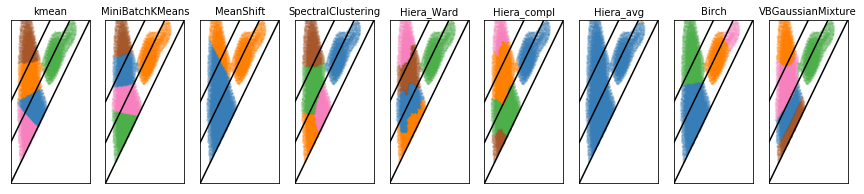

In [12]:
filenames  = ['data_T1T2\Pro_T1T2_3_14_H_20_35_2_03272016.txt',
              #'data_T1T2\Pro_T1T2_3_14_H_20_35_21_05092016.txt',
              #'data_T1T2\Pro_T1T2_3_14_h_20_35_250c_08132016.txt',
              #'data_T1T2\Pro_T1T2_3_14_h_20_35_450c_09192016.txt',
              #'data_T1T2\Pro_T1T2_3_14_h_20_35_650c.txt',                
]


default_base = {'quantile': .3,
                'eps': .03,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 5}

model_Gs = []
model_BGs = []
titles = ['NORM 30c','NORM 110c','NORM 250c','NORM 450c','NORM 650c']
for i,file in enumerate(filenames):
    Z_grid = np.loadtxt(file) 
    #plot_raw(T2_grid, T1_grid, Z_grid, titles[i])
    X_den_v, Y_den_v = to_density(T2_grid, T1_grid, Z_grid, ratio=0.1, scale = 0.01) 
    X_train = np.vstack([np.array(X_den_v), np.array(Y_den_v)]).T
    print(X_train.shape)
    
    
    params = default_base.copy()
        # connectivity matrix for structured Ward
    bandwidth = cluster.estimate_bandwidth(X_train, quantile=params['quantile'])
    connectivity = kneighbors_graph(
        X_train, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    
    # algo
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    #gmm = mixture.GaussianMixture(
        #n_components=params['n_clusters'], covariance_type='full')
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    kmean = cluster.KMeans(n_clusters=params['n_clusters'])
    dbscan = cluster.DBSCAN(eps=params['eps'],min_samples=100)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    ward = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage = 'ward')
    complete = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'],linkage ='complete')
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    
    VBGMM = mixture.BayesianGaussianMixture(n_components=params['n_clusters'], covariance_type='full',max_iter=1000)
            #clf_BG.fit(X_train)
    
    clustering_algorithms = (
        ('kmean',kmean),
        ('MiniBatchKMeans', two_means),
        #('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Hiera_Ward', ward),
        ('Hiera_compl', complete),
        #('Hiera_avg', average),
        ('Hiera_avg', average_linkage),
        #('DBSCAN', dbscan),
        ('Birch', birch),
        ('VBGaussianMixture', VBGMM)
    )
    
    plt.figure(figsize=(15,3))
    plot_num = 1
    
    for name, algorithm in clustering_algorithms:
        t0 = time.time()
        algorithm.fit(X_train)
        
        t1 = time.time()
        print('{}: {}'.format(name,str(np.round(t1-t0,3))))
        
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        
        else:
            y_pred = algorithm.predict(X_train)
        
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        

        plt.subplot(1, len(clustering_algorithms), plot_num)
        
        plt.title(name, size=10)
        plt.scatter(X_train[:, 0], X_train[:, 1], s=2, color=colors[y_pred], alpha=0.2)
        plt.plot([-2,3],[-2,3],'k')
        plt.plot([-2,3],[-1,4],'k')
        plt.plot([-2,3],[0,5],'k')
        plt.xlim(-2., 2.)
        plt.ylim(-2., 2.)
        plt.xticks(())
        plt.yticks(())
        
        plot_num += 1
    
    #model_kmean = 
    #model_kmean.fit(X_train)
    #labels = model_kmean.labels_
    #cluster_center = model_kmean. cluster_centers_


(4585, 2)
kmean: 0.018
MiniBatchKMeans: 0.013
MeanShift: 0.065
SpectralClustering: 0.847
Hiera_Ward: 0.458
Hiera_compl: 0.316
Hiera_avg: 0.221
Birch: 0.059
VBGaussianMixture: 0.02


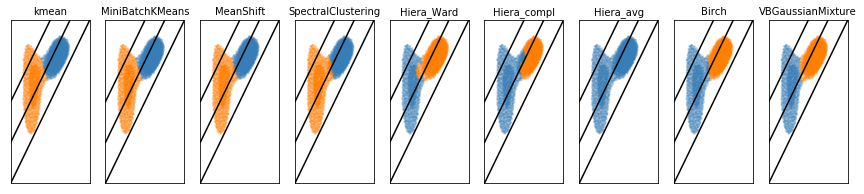

In [18]:
filenames  = ['data_T1T2\Pro_T1T2_2_93_P_20_35_0(a)_05152016.txt',
              #'data_T1T2\Pro_T1T2_3_14_H_20_35_21_05092016.txt',
              #'data_T1T2\Pro_T1T2_3_14_h_20_35_250c_08132016.txt',
              #'data_T1T2\Pro_T1T2_3_14_h_20_35_450c_09192016.txt',
              #'data_T1T2\Pro_T1T2_3_14_h_20_35_650c.txt',                
]

default_base = {'quantile': .3,
                'eps': .03,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 2}

model_Gs = []
model_BGs = []
titles = ['NORM 30c','NORM 110c','NORM 250c','NORM 450c','NORM 650c']
for i,file in enumerate(filenames):
    Z_grid = np.loadtxt(file) 
    #plot_raw(T2_grid, T1_grid, Z_grid, titles[i])
    X_den_v, Y_den_v = to_density(T2_grid, T1_grid, Z_grid, ratio=0.1, scale = 0.01) 
    X_train = np.vstack([np.array(X_den_v), np.array(Y_den_v)]).T
    print(X_train.shape)
    
    
    params = default_base.copy()
        # connectivity matrix for structured Ward
    bandwidth = cluster.estimate_bandwidth(X_train, quantile=params['quantile'])
    connectivity = kneighbors_graph(
        X_train, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    
    # algo
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    #gmm = mixture.GaussianMixture(
        #n_components=params['n_clusters'], covariance_type='full')
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    kmean = cluster.KMeans(n_clusters=params['n_clusters'])
    dbscan = cluster.DBSCAN(eps=params['eps'],min_samples=100)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    ward = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage = 'ward')
    complete = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'],linkage ='complete')
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    
    VBGMM = mixture.BayesianGaussianMixture(n_components=params['n_clusters'], covariance_type='full',max_iter=1000)
            #clf_BG.fit(X_train)
    
    clustering_algorithms = (
        ('kmean',kmean),
        ('MiniBatchKMeans', two_means),
        #('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Hiera_Ward', ward),
        ('Hiera_compl', complete),
        #('Hiera_avg', average),
        ('Hiera_avg', average_linkage),
        #('DBSCAN', dbscan),
        ('Birch', birch),
        ('VBGaussianMixture', VBGMM)
    )
    
    plt.figure(figsize=(15,3))
    plot_num = 1
    
    for name, algorithm in clustering_algorithms:
        t0 = time.time()
        algorithm.fit(X_train)
        
        t1 = time.time()
        print('{}: {}'.format(name,str(np.round(t1-t0,3))))
        
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        
        else:
            y_pred = algorithm.predict(X_train)
        
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))

        plt.subplot(1, len(clustering_algorithms), plot_num)
        
        plt.title(name, size=10)
        plt.scatter(X_train[:, 0], X_train[:, 1], s=2, color=colors[y_pred], alpha=0.2)
        plt.plot([-2,3],[-2,3],'k')
        plt.plot([-2,3],[-1,4],'k')
        plt.plot([-2,3],[0,5],'k')
        plt.xlim(-2., 2.)
        plt.ylim(-2., 2.)
        plt.xticks(())
        plt.yticks(())
        
        plot_num += 1
    
    #model_kmean = 
    #model_kmean.fit(X_train)
    #labels = model_kmean.labels_
    #cluster_center = model_kmean. cluster_centers_

In [34]:
cluster_center = model_kmean.cluster_centers_
    # plot
    fig = plt.figure( figsize=(5, 5))
    s = [10 for n in range(len(X_train))]
    plt.scatter(X_train[:,0], X_train[:, 1], c=labels.astype(np.float), alpha=0.5, s=s )
    
    for (x,y) in cluster_center:
        plt.plot(x,y,'r*')
    
    plt.title(titles[i]+'_'+'kmean')
    plt.plot([-2,3],[-2,3],'k')
    plt.plot([-2,3],[-1,4],'k')
    plt.plot([-2,3],[0,5],'k')
    plt.xlim(-2., 3.)
    plt.ylim(-2., 3.)
    plt.xlabel('log T2 (ms)')
    plt.ylabel('log T1 (ms)')

array([[-1.07861738,  1.30492066],
       [-0.8437974 , -0.1521752 ],
       [ 0.26957315,  1.1268388 ],
       [-1.10994453, -0.67478665],
       [-1.03977057,  0.49698564]])